**Problem 2.c - Neural Network Regression with weigh decay and dropout**

In [1]:
import torch
!pip install d2l==0.14.2 
!pip install -U mxnet-cu101mkl==1.6.0
!pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mxnet-cu101mkl==1.6.0 (from versions: 1.4.1, 1.5.0, 1.5.1, 1.5.1.post0, 1.6.0.post0)
ERROR: No matching distribution found for mxnet-cu101mkl==1.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 KB 3.0 MB/s eta 0:00:00
  Attempting uninstall: d2l
    Found existing installation: d2l 0.14.2
    Uninstalling d2l

In [2]:
!pip show d2l

Name: d2l
Version: 1.0.0a0
Summary: Dive into Deep Learning
Home-page: https://d2l.ai
Author: D2L Developers
Author-email: d2l.devs@gmail.com
License: MIT-0
Location: /usr/local/lib/python3.8/dist-packages
Requires: gym, jupyter, matplotlib, numpy, pandas, requests
Required-by: 


In [3]:
!pip install matplotlib
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%matplotlib inline
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files
uploaded = files.upload()

Saving testhouse.csv.csv to testhouse.csv.csv
Saving trainhouse.csv.csv to trainhouse.csv.csv


In [6]:
import pandas as pd
import io
train = pd.read_csv(io.BytesIO(uploaded['trainhouse.csv.csv']))

In [7]:
test = pd.read_csv(io.BytesIO(uploaded['testhouse.csv.csv']))

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [10]:
print(train.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [11]:
all_features = pd.concat((train.iloc[:, 1:-1], test.iloc[:, 1:]))

In [12]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

In [13]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [15]:
n_train = train.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

In [16]:
test_features.shape

torch.Size([1459, 331])

In [17]:
import torch
from torch import nn
loss = nn.MSELoss()
in_features = train_features.shape[1]

In [18]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features,256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256,128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 1))
    return net

In [19]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [20]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [21]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [22]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.123905, valid log rmse 0.169721
fold 2, train log rmse 0.128973, valid log rmse 0.146307
fold 3, train log rmse 0.126726, valid log rmse 0.158091
fold 4, train log rmse 0.125929, valid log rmse 0.182076
fold 5, train log rmse 0.125083, valid log rmse 0.181227
fold 6, train log rmse 0.126597, valid log rmse 0.136207
fold 7, train log rmse 0.127360, valid log rmse 0.162455
fold 8, train log rmse 0.127772, valid log rmse 0.146742
fold 9, train log rmse 0.117870, valid log rmse 0.188240
fold 10, train log rmse 0.118745, valid log rmse 0.150514
10-fold validation: avg train log rmse: 0.124896, avg valid log rmse: 0.162158


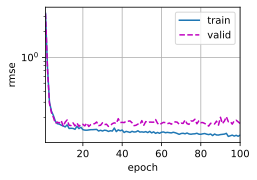

In [24]:
from d2l import torch as d2l
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 0.01, 0.7, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')